# Extracting an Order Parameter

When your system of interest undergoes a phase transition, it is helpful to track to the temperature dependence of the relevant features in the scattering data which provides a measure of the underlying order parameter. 

If you don't know where in your scattering dataset to look, machine learning tools like [XTEC](https://github.com/KimGroup/XTEC) can help cluster pixels into groups by their temperature trajectories, possibly revealing a phase transition in your dataset. 

For this example, we assume that we know where to look -- we have a phase transition involving the onset of half-integer reflections along _H_ below approximately _T_ = 50 K. 

First, let's load in the datasets corresponding to the temperature-dependent scans on our pretend sample. For this, we use the `TempDependence` class from `nxs_analysis_tools.chess`. For more information on loading temperature-dependent scans, see [this example](https://nxs-analysis-tools.readthedocs.io/en/latest/examples/working_with_chess_data.html).

In [1]:
from nxs_analysis_tools.chess import TempDependence

# Create the TempDependence object
xtl = TempDependence()
# Set the sample directory (the directory holding the temperature folders)
xtl.set_sample_directory('example_data/order_parameter/nxrefine/CsV3Sb5/sample_1b/')
# Load the transforms (i.e., transformed datasets produced by nxrefine)
xtl.load_transforms(print_tree=False)

Next, let's use the `plot_slice` function to examine the _HK_ plane of the highest temperature (_T_ = 300 K) and the lowest temperature (_T_ = 15 K).

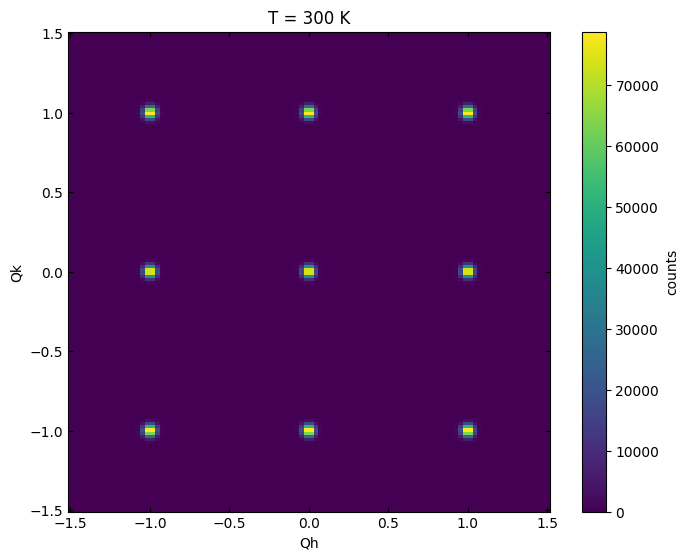

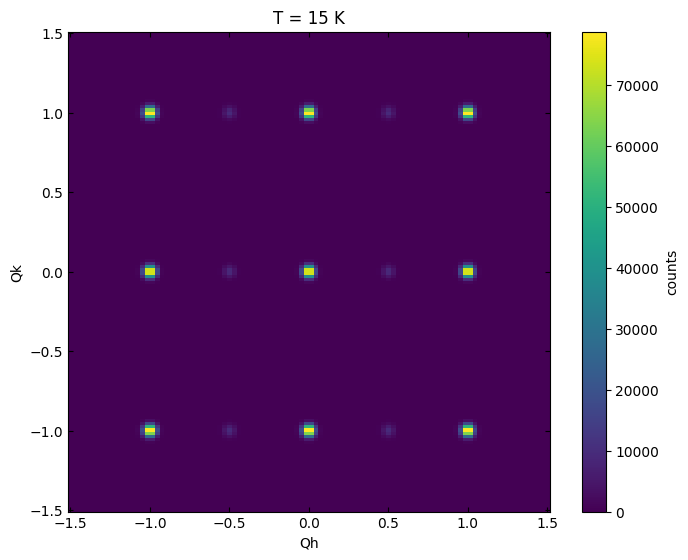

In [2]:
from nxs_analysis_tools.datareduction import plot_slice

plot_slice(xtl.datasets['300'][:,:,0.0], title='T = 300 K')
plot_slice(xtl.datasets['15'][:,:,0.0], title='T = 15 K')

Clearly, we have some weak half integer reflections along _H_ which are only present at low temperature.

## Visualizing the phase transition

As a first step to parameterizing this phase transition, we can perform a linecut ([learn more](https://nxs-analysis-tools.readthedocs.io/en/latest/examples/using_scissors.html)) that passes through the half-integer reflections.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Qh 0.0 0.0', ylabel='counts'>)

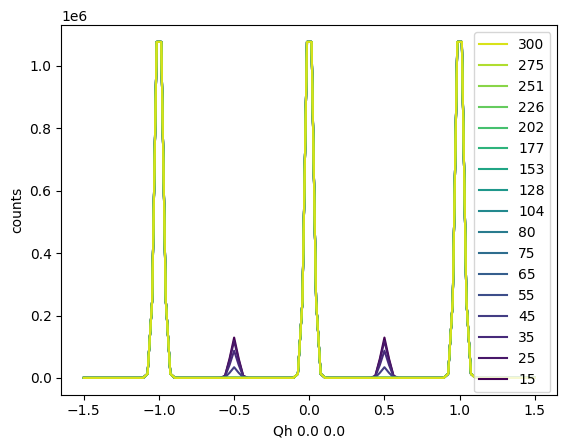

In [3]:
xtl.cut_data(center=(0.0,0.0,0.0), window=(1.5,0.2,0.2))
xtl.plot_linecuts()

This plot of the linecut reveals the half integer peaks, but it's hard to tell at exactly what temperature they turn on... To better visualize this, we can plot the linecuts as a heatmap in reciprocal space at various temperatures using the `.plot_linecuts_heatmap()` method.

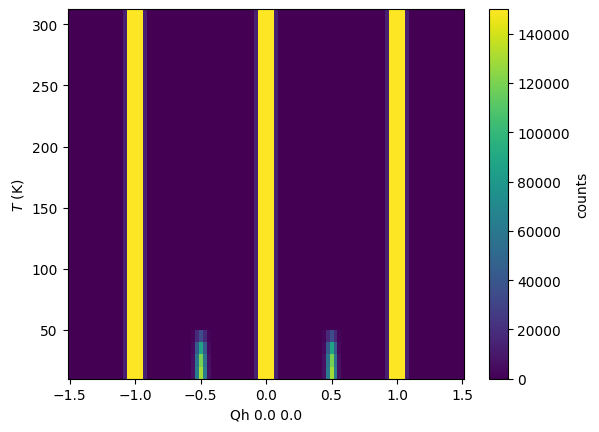

In [4]:
xtl.plot_linecuts_heatmap(vmin=0, vmax=1.5e5)

Here, it's easier to see that the half integer peaks turn on at about _T_ = 50 K, marking the phase transition temperature.

## Fitting an order parameter

A more quantitative approach here is to combine this analysis with a fitting of the half-integer peaks, which will allow us to quantitatively track the order parameter by examining the temperature dependence of the peak parameters (_e.g._, peak height, peak width).

First, let's narrow our linecut to only include a single half-integer reflection of interest.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Qh 0.0 0.0', ylabel='counts'>)

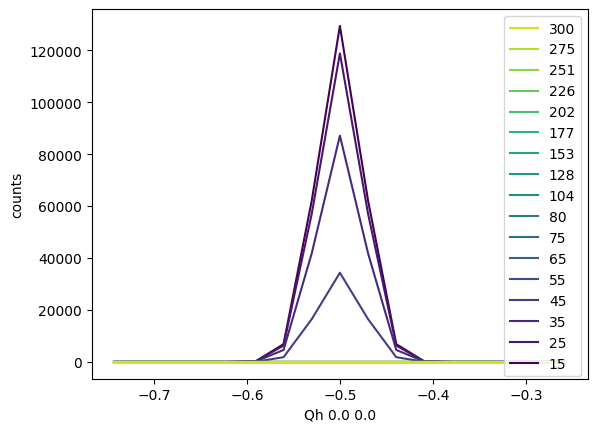

In [5]:
xtl.cut_data(center=(-0.5,0.0,0.0), window=(0.25,0.2,0.2))
xtl.plot_linecuts()

As above, we can also plot the heatmap version of the same plot, which allows us to clearly see the transition.

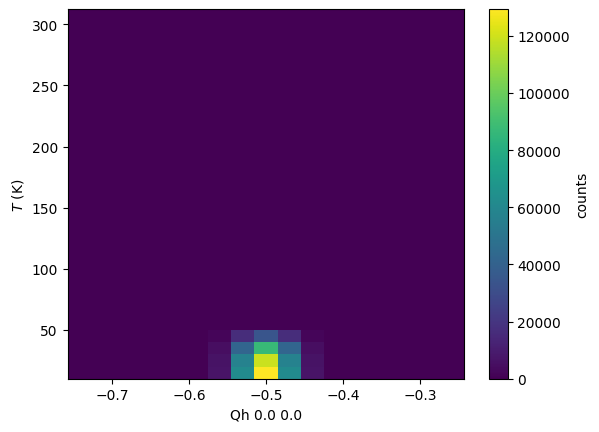

In [6]:
xtl.plot_linecuts_heatmap()

Next, we can use the fitting tools in `nxs_analysis_tools` to fit these peaks ([learn more](https://nxs-analysis-tools.readthedocs.io/en/latest/examples/fitting_chess_data.html)).

In [7]:
from lmfit.models import GaussianModel, LinearModel

# Set the model components for the peak and background
xtl.set_model_components([GaussianModel(prefix='peak'), LinearModel(prefix='background')])

# Initialize the parameters for the model
xtl.make_params()

# Perform an initial guess
xtl.guess()

# Add in some helpful constraints
for T in xtl.temperatures:
    # Constrain the peak center to fall between -0.6 and -0.4 along H
    xtl.linecutmodels[T].params['peakcenter'].set(value=-0.5, min=-0.6, max=-0.4)
    # Constrain the peak amplitude to positive values
    xtl.linecutmodels[T].params['peakamplitude'].set(min=0)

# Perform the fitting procedure
xtl.fit()

# Optional: view the resulting fits
# xtl.plot_fit()

Fits completed.


Now that the fits have been completed, we can use the `.plot_order_parameter()` method to plot the temperature dependence of the `peakheight` parameter in the model, which gives us a good measure of the order parameter across the phase transition.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$T$ (K)', ylabel='peakheight'>)

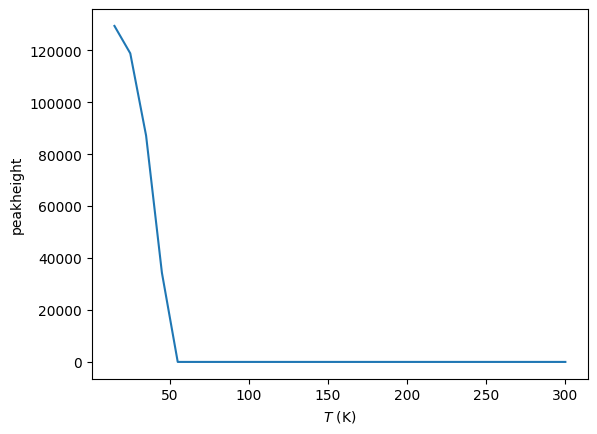

In [8]:
xtl.plot_order_parameter()